# 여러 회사의 주가 예측하기

```
실습목표
1. 주식 데이터셋을 야후로부터 불러와서 모델에 입력가능한 형태로 변환합니다.
2. 시계열 데이터의 특징을 이해하고 EDA 및 F.E 를 진행합니다.
3. Cross Validation 을 통해 Hyper Parameter Tunning 을 진행하여 성능을 높여봅니다.
```


```
실습단계
1. 라이브러리 임포트
2. 데이터셋 로드 및 전처리
3. EDA 및 F.E
4. 모델 로드 및 학습
5. 모델 평가 및 예측
6. 모델 결과 시각화

```


## Mission : 아래 코드를 모두 수행하여 AAPL 의 주가를 예측합니다.

- (선택) ALL Stock 데이터에 대해서도 각각 종목별로 주가를 예측합니다.
- (선택2) 기존에 사용했던 WandB 를 활용하여 CV 시에 파라미터 별 성능을 기록합니다.

### 1.라이브러리 임포트

In [ ]:
import yfinance as yf
import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### 2.데이터셋 로드 및 전처리

In [ ]:
# Define the stock symbol and the date range
stock_symbol = 'AAPL'  # Example: Apple Inc.
start_date = '2000-01-01'
end_date = '2023-12-31'

# Fetch the stock data
stock_data_AAPL = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
print(stock_data_AAPL.head())

# Save to a CSV file if needed
stock_data_AAPL.to_csv('stock_data_AAPL.csv')

[*********************100%%**********************]  1 of 1 completed


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2000-01-03  0.936384  1.004464  0.907924  0.999442   0.844981  535796800
2000-01-04  0.966518  0.987723  0.903460  0.915179   0.773740  512377600
2000-01-05  0.926339  0.987165  0.919643  0.928571   0.785063  778321600
2000-01-06  0.947545  0.955357  0.848214  0.848214   0.717125  767972800
2000-01-07  0.861607  0.901786  0.852679  0.888393   0.751094  460734400


In [ ]:
stock_data_AAPL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844981,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.773740,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.785063,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.717125,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.751094,460734400


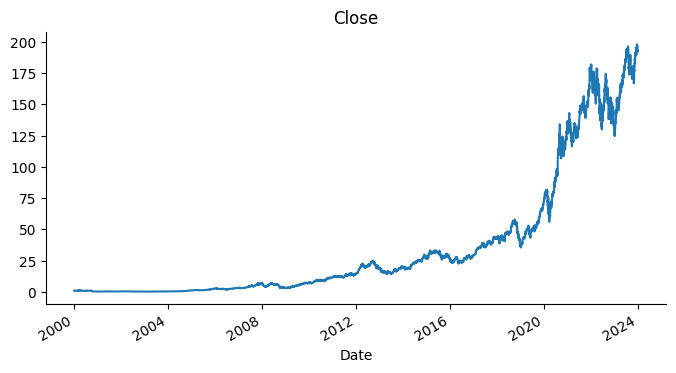

In [ ]:
# @title Close (only APPLE)

from matplotlib import pyplot as plt
stock_data_AAPL['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

#### (Opt) 2-1.AAPL 외에 다른 주식들도 한번에 불러올 수는 없을까?

In [ ]:
# Define the list of stock symbols
stock_symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']  # Example symbols

# Define the date range
start_date = '2000-01-01'
end_date = '2023-12-31'

# Initialize an empty DataFrame to hold all stock data
all_stock_data = pd.DataFrame()

# Fetch and concatenate data for each stock symbol
for symbol in stock_symbols:
    # Fetch the stock data
    stock_data = yf.download(symbol, start=start_date, end=end_date)

    # Add a column for the stock symbol
    stock_data['Symbol'] = symbol

    # Append to the all_stock_data DataFrame
    all_stock_data = pd.concat([all_stock_data,stock_data])

# Reset the index to handle the concatenation
all_stock_data.reset_index(inplace=True)

# Display the first few rows of the combined data
print(all_stock_data.head())

# Save to a CSV file if needed
all_stock_data.to_csv('multiple_stocks_data.csv', index=False)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


        Date      Open      High       Low     Close  Adj Close     Volume  \
0 2000-01-03  0.936384  1.004464  0.907924  0.999442   0.844981  535796800   
1 2000-01-04  0.966518  0.987723  0.903460  0.915179   0.773740  512377600   
2 2000-01-05  0.926339  0.987165  0.919643  0.928571   0.785063  778321600   
3 2000-01-06  0.947545  0.955357  0.848214  0.848214   0.717125  767972800   
4 2000-01-07  0.861607  0.901786  0.852679  0.888393   0.751094  460734400   

  Symbol  
0   AAPL  
1   AAPL  
2   AAPL  
3   AAPL  
4   AAPL  


In [ ]:
all_stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
26381,2023-12-22,256.760010,258.220001,251.369995,252.539993,252.539993,93249800,TSLA
26382,2023-12-26,254.490005,257.970001,252.910004,256.609985,256.609985,86892400,TSLA
26383,2023-12-27,258.350006,263.339996,257.519989,261.440002,261.440002,106494400,TSLA
26384,2023-12-28,263.660004,265.130005,252.710007,253.179993,253.179993,113619900,TSLA
26385,2023-12-29,255.100006,255.190002,247.429993,248.479996,248.479996,100615300,TSLA


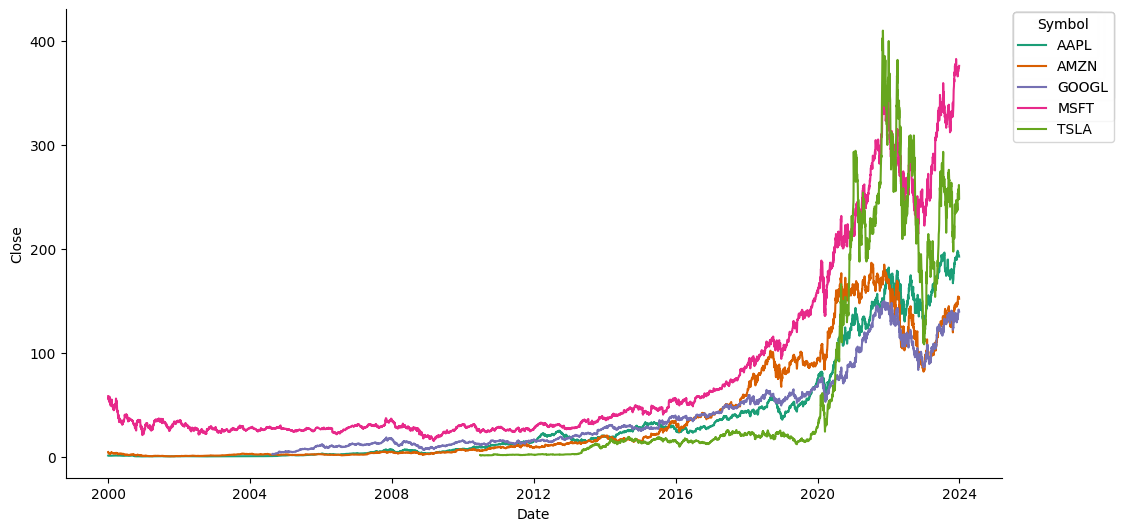

In [ ]:
# @title Close (for all stocks)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = all_stock_data.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Symbol')):
  _plot_series(series, series_name, i)
  fig.legend(title='Symbol', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')

### 3.EDA 및 F.E

In [ ]:
# Load the dataset
data = stock_data_AAPL.reset_index()  # Reset index to get 'Date' as a column

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844981,535796800
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.773740,512377600
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.785063,778321600
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.717125,767972800
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.751094,460734400
...,...,...,...,...,...,...,...
6032,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
6033,2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
6034,2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700
6035,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.071426,34049900


In [ ]:
type(data['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Date']

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
6032   2023-12-22
6033   2023-12-26
6034   2023-12-27
6035   2023-12-28
6036   2023-12-29
Name: Date, Length: 6037, dtype: datetime64[ns]

F.E(Feature Engineering) , 시계열 데이터의 종가기준 10, 50일 선 계산

| 열 이름 | 의미 |
| --- | --- |
| Date | 거래 날짜. 주식이 거래된 날짜를 나타냅니다. |
| Open | 시가. 해당 거래일의 시작 시점에서 주식의 가격입니다. |
| High | 고가. 해당 거래일 동안 주식의 최고 가격입니다. |
| Low | 저가. 해당 거래일 동안 주식의 최저 가격입니다. |
| Close | 종가. 해당 거래일의 마지막 거래 가격입니다. |
| Adj Close | 수정 종가. 주식 배당, 주식 분할 등의 요인을 반영한 종가입니다. |
| Volume | 거래량. 해당 거래일 동안 거래된 주식의 수량입니다. |
| Symbol | 주식 종목 코드. 특정 주식 종목을 식별하는 코드입니다. |
| MA10 | 10일 이동 평균. 최근 10일 동안의 종가의 평균입니다. |
| MA50 | 50일 이동 평균. 최근 50일 동안의 종가의 평균입니다. |
| Lag1 | 1일 전 종가. 이전 거래일의 종가를 나타냅니다. |
| Lag2 | 2일 전 종가. 이전 두 거래일 전의 종가를 나타냅니다. |
| Volatility | 변동성. 최근 10일 동안의 종가의 표준 편차를 나타냅니다. |

In [ ]:
# Example feature engineering: Adding moving averages
data['MA10'] = data['Close'].rolling(window=10).mean() ### ### rolling , mean 활용
data['MA50'] = data['Close'].rolling(window=50).mean() ### rolling , mean 활용

In [ ]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50
count,6037,6037.000000,6037.000000,6037.000000,6037.000000,6037.000000,6.037000e+03,6028.000000,5988.000000
mean,2012-01-02 03:12:00.954116096,35.836839,36.227569,35.461397,35.861158,34.463051,3.996452e+08,35.769486,35.367676
min,2000-01-03 00:00:00,0.231964,0.235536,0.227143,0.234286,0.198078,2.404830e+07,0.238482,0.255500
25%,2006-01-04 00:00:00,2.173214,2.202500,2.130000,2.170000,1.834633,1.290580e+08,2.190375,2.255037
50%,2011-12-30 00:00:00,14.465357,14.616071,14.329286,14.480714,12.332439,2.810528e+08,14.535911,14.693614
75%,2017-12-29 00:00:00,41.345001,41.862499,40.869999,41.312500,39.168839,5.333888e+08,41.292250,41.092112
max,2023-12-29 00:00:00,198.020004,199.619995,197.000000,198.110001,197.589523,7.421641e+09,195.958002,187.442600
std,NaN,51.002750,51.568311,50.478962,51.050850,50.717337,3.855627e+08,50.878698,50.133817


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6037 entries, 0 to 6036
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6037 non-null   datetime64[ns]
 1   Open       6037 non-null   float64       
 2   High       6037 non-null   float64       
 3   Low        6037 non-null   float64       
 4   Close      6037 non-null   float64       
 5   Adj Close  6037 non-null   float64       
 6   Volume     6037 non-null   int64         
 7   MA10       6028 non-null   float64       
 8   MA50       5988 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 424.6 KB


In [ ]:
# Drop rows with NaN values created by rolling windows
data.dropna(inplace=True)

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50
49,2000-03-14,1.082310,1.109375,1.017857,1.020089,0.862437,428579200,1.102176,0.988284
50,2000-03-15,1.032366,1.073661,1.018973,1.037946,0.877534,443609600,1.089621,0.989054
51,2000-03-16,1.047433,1.089286,1.022321,1.085379,0.917637,378100800,1.089230,0.992458
52,2000-03-17,1.072545,1.116071,1.068080,1.116071,0.943585,305043200,1.086551,0.996208
53,2000-03-20,1.102679,1.127232,1.092634,1.098214,0.928488,204489600,1.084152,1.001208


#### (Opt) 3-1.ALL Stocks 에서 F.E

In [ ]:
all_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844981,535796800,AAPL
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.773740,512377600,AAPL
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.785063,778321600,AAPL
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.717125,767972800,AAPL
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.751094,460734400,AAPL


In [ ]:
# Feature Engineering: Moving Averages
all_stock_data['MA10'] = all_stock_data.groupby('Symbol')['Close'].transform(lambda x : x.rolling(window=10).mean()) # group by , rolling
all_stock_data['MA50'] = all_stock_data.groupby('Symbol')['Close'].transform(lambda x : x.rolling(window=50).mean()) # group by , rolling

# Feature Engineering: Lag Features , 전날 , 전전날 종가 표시
all_stock_data['Lag1'] = all_stock_data.groupby('Symbol')['Close'].shift(1) # pandas shift
all_stock_data['Lag2'] = all_stock_data.groupby('Symbol')['Close'].shift(2) # pandas shift

# Feature Engineering: Volatility (Standard Deviation of the closing prices over a window)
all_stock_data['Volatility'] = all_stock_data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=10).std())

# Drop rows with NaN values created by rolling windows and lag features
all_stock_data.dropna(inplace=True)

# Display the first few rows of the enhanced data
print(all_stock_data.head())

# Save to a CSV file if needed
all_stock_data.to_csv('enhanced_multiple_stocks_data.csv', index=False)

         Date      Open      High       Low     Close  Adj Close     Volume  \
49 2000-03-14  1.082310  1.109375  1.017857  1.020089   0.862437  428579200   
50 2000-03-15  1.032366  1.073661  1.018973  1.037946   0.877534  443609600   
51 2000-03-16  1.047433  1.089286  1.022321  1.085379   0.917637  378100800   
52 2000-03-17  1.072545  1.116071  1.068080  1.116071   0.943585  305043200   
53 2000-03-20  1.102679  1.127232  1.092634  1.098214   0.928488  204489600   

   Symbol      MA10      MA50      Lag1      Lag2  Volatility  
49   AAPL  1.102176  0.988284  1.083147  1.122768    0.039177  
50   AAPL  1.089621  0.989054  1.020089  1.083147    0.037419  
51   AAPL  1.089230  0.992458  1.037946  1.020089    0.037443  
52   AAPL  1.086551  0.996208  1.085379  1.037946    0.033978  
53   AAPL  1.084152  1.001208  1.116071  1.085379    0.031968  


#### 3-2.특성 선택 및 데이터 분할

- 학습에 사용할 특성(features)들만 선택한다.

In [ ]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA10',
       'MA50'],
      dtype='object')

In [ ]:
# Preparing features and target variable
# Assuming 'Close' is the target variable
features = ['Open', 'High', 'Low', 'Volume', 'MA10',
       'MA50'] # feature selection
X = data[features]
y = data['Close']

In [ ]:
from sklearn.feature_selection import VarianceThreshold , SelectKBest, chi2

# selector = VarianceThreshold(threshold=0)
# X_selected = selector.fit_transform(X)

In [ ]:
corr_mat = data.corr().abs()
# corr_mat['Close']
threshold = 0.8
high_corr_feat = corr_mat.index[corr_mat['Close'] > threshold].tolist()
X_selected =data[high_corr_feat]

In [ ]:
X_selected

,Date,Open,High,Low,Close,Adj Close,MA10,MA50
49,2000-03-14,1.082310,1.109375,1.017857,1.020089,0.862437,1.102176,0.988284
50,2000-03-15,1.032366,1.073661,1.018973,1.037946,0.877534,1.089621,0.989054
51,2000-03-16,1.047433,1.089286,1.022321,1.085379,0.917637,1.089230,0.992458
52,2000-03-17,1.072545,1.116071,1.068080,1.116071,0.943585,1.086551,0.996208
53,2000-03-20,1.102679,1.127232,1.092634,1.098214,0.928488,1.084152,1.001208
...,...,...,...,...,...,...,...,...
6032,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,195.747002,185.398801
6033,2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,195.734003,185.682801
6034,2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,195.578001,185.971400
6035,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.071426,195.140001,186.300001


- train, test 데이터로 분리한다.

In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.모델 로드 및 학습

In [ ]:
# Training the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### 5.모델 평가 및 예측


In [ ]:
# Making predictions and evaluating the model
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.5840396350722347


#### 5-1.모델 고도화하기

- Cross Validation 을 통해 Hyper Parameter Tunning 해주기

In [ ]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
# Training the final model with the best parameters
final_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
final_pred = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_pred)
print(f"Final Mean Squared Error: {final_mse}")

Final Mean Squared Error: 0.4822153565274709


### 6.모델 결과 시각화

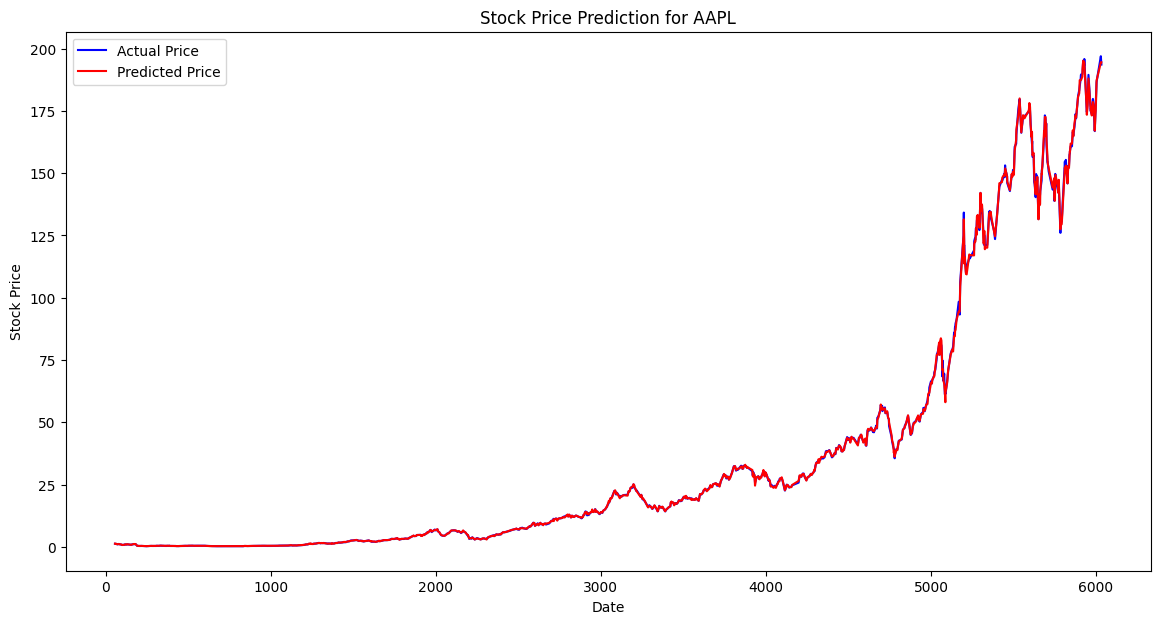

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame for visualization
visualization_df = X_test.copy()
visualization_df['Actual'] = y_test
visualization_df['Predicted'] = final_pred
visualization_df = visualization_df.sort_index()  # Ensure the data is sorted by date

# Plotting the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(visualization_df.index, visualization_df['Actual'], label='Actual Price', color='blue')
plt.plot(visualization_df.index, visualization_df['Predicted'], label='Predicted Price', color='red')
plt.fill_between(visualization_df.index, visualization_df['Actual'], visualization_df['Predicted'], color='gray', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'Stock Price Prediction for AAPL')
plt.legend()
plt.show()